In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model, Sequential
from keras.layers import Input, Dense, Layer, Flatten, Reshape
from keras.losses import Loss
from keras.optimizers import Optimizer
from tensorflow.keras.utils import to_categorical, plot_model, load_img, img_to_array

from keras.models import load_model

In [3]:
def plot_img(data):
    # show figures in the dataset
    fig = plt.figure(figsize = (24,3))
    plt.imshow(data.reshape(28,28) , cmap = plt.get_cmap('gray'))
    plt.show()

# Autoencoder: Layer Classes

We gonna create an autoencoder with a Layer class Encoder, a Latent class for the bottleneck, and a Layer class Decoder.
The Encoder class can take the input tensor and encode it into a lower-dimensional representation, which is then passed to the Latent class. The Latent class can perform any additional processing on the representation, such as adding noise or performing regularization. The Decoder class takes the output of the Latent class and decodes it back into the original input shape.

By training the autoencoder to minimize the difference between the original input and the decoded output, the model can learn to compress and reconstruct the input data in a lower-dimensional space. This approach allows for modular design and easier customization of the autoencoder architecture.

The number of hidden layers in an encoder layer depends on the complexity of the input data. with this modular design we cans set then when call the ``Encoder`` class. In general, autoencoders can have multiple hidden layers, typically ranging from 1 to 3. 

- The number of hidden layers in the encoder is a hyperparameter that needs to be tuned to achieve the best performance on the given task. 
- adding too many layers can lead to overfitting, while too few layers may not be able to capture the complexity of the input data.

Another important point is that we can use different activation functions in the hidden layer(s) and the latent layer in an autoencoder with this design. Typically, nonlinear activation functions such as ReLU, sigmoid, or tanh are used in the hidden layers to introduce nonlinearity. In the latent layer, the activation function is usually chosen based on the specific application and the desired properties of the output. For example, if the output should be continuous and bounded, a ``sigmoid`` or ``tanh`` activation function might be used, while if the output should be sparse, a ``ReLU`` or a ``softmax`` function might be used.

In [22]:
class Encoder(Layer):
    def __init__(self, layer_sizes: list[int] = [100], activation: str = 'relu', initializer: str = "he_uniform") -> None:
        """
        Encoder Layer.

        Parameters:
        layer_sizes (List[int]): A list containing the number of units to be used in each Dense layer.
        activation (str): The activation function to be used in the Dense layers.
        initializer (str): The initializer to be used in the Dense layers.
        """

        super(Encoder, self).__init__()
        self.layer_size = layer_sizes
        self.activation = activation
        self.initializer = initializer

        # Flatten Layer
        self.flatten = Flatten(name='Flatten')

        # Hidden Layers
        self.layers = []
        count = 0
        for size in layer_sizes:
            self.layers.append(Dense(units=size,
                                     kernel_initializer=self.initializer,
                                     activation=self.activation,
                                     name='DenseEncoder_{}'.format(count)))
            count += 1

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Performs the forward pass of the encoder layer.

        Parameters:
        x (tf.Tensor): The input tensor to be encoded.

        Returns:
        tf.Tensor: The encoded tensor.
        """

        x = self.flatten(x)
        for layer in self.layers:
            x = layer(x)
        return x


In [23]:
class Latent(Layer):
    def __init__(self, encoder: Encoder, layer_sizes: list = [20], activation: str = 'relu', initializer: str = "he_uniform") -> None:
        """
        Latent Layer.
        
        Parameters:
        encoder (Encoder): An instance of the Encoder class.
        layer_sizes (list): A list containing the number of units to be used in each hidden layer.
        activation (str): The activation function to be used in the hidden layers.
        initializer (str): The initializer to be used in the hidden layers.
        """
        super(Latent, self).__init__()
        
        self.encoder = encoder
        self.layer_size = layer_sizes
        self.activation = activation
        self.initializer = initializer
        
        # Encoder Layer   
        self.encoder_layer = encoder

        # Latent Layer    
        self.layers = []    
        count = 0
        for size in layer_sizes:
            self.layers.append( Dense( units = size, 
                                       kernel_initializer = self.initializer, 
                                       activation = self.activation,
                                       name = 'DenseLatent_{}'.format(count) ) )
            count += 1
        
        # Invert list of encoder layers to pass as the decoder layers
        # Decoder class will have access to decoder_layers
        self.decoder_layer_sizes = encoder.layer_size[::-1]

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Forward step for the Latent layer.
        
        Parameters:
        x (Tensor): The input tensor.
        
        Returns:
        Tensor: output tensor.
        """
        for layer in self.layers:
            x = layer(x)
        return x


The parameter ``input_img_size`` in the Decoder class is a tuple of integers representing the size of the input image. This parameter is used to calculate the number of units in the output layer by taking the product of the elements in the tuple, which is equivalent to the total number of pixels in the input image. 

In [25]:
class Decoder(Layer):
    def __init__(self, latent: Latent, activation: str = 'relu', output_activation: str = 'sigmoid',  initializer: str = "he_uniform", input_img_size: int = (28,28) ) -> None:
        """Decoder Layer.

        Parameters:
        - latent: Latent object used to access the decoder layer sizes.
        
        - activation: Activation function for the dense layers.

        - output_activation: Activation function for the output layers.

        - initializer: Weights initializer for the dense layers.

        - input_img_size: Is the size of each image in the dataset. 
           Used to calculate the number of units in the output layer. 
        """
        super(Decoder, self).__init__()
        
        self.latent = latent
        self.activation = activation
        self.output_activation = output_activation
        self.initializer = initializer
        self.input_img_size = input_img_size

        # Output size defined accordingly to the Encoder input layer size
        # the idea is generate a symmetric number of layers compared to the Encoder
        self.layer_sizes = latent.decoder_layer_sizes

        # Hidden Layer
        self.layers = []
        count = 0
        for size in self.layer_sizes:
            self.layers.append(Dense(units=size, 
                                     kernel_initializer=self.initializer, 
                                     activation=self.activation,
                                     name='DenseDecoder_{}'.format(count)))
            count += 1
        
        self.layers.append(Dense(units= np.prod(self.input_img_size), 
                                 kernel_initializer=self.initializer, 
                                 activation=self.output_activation, 
                                 name='Output'))
        
        self.reshape = Reshape(target_shape=self.input_img_size)
    
    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Perform the forward step of the decoder layer.

        Parameters:
        x (Tensor): The input tensor.
        
        Returns:
        Tensor: output tensor.
        
        """
        for layer in self.layers:
            x = layer(x)
        x = self.reshape(x)
        return x


## Model Summary

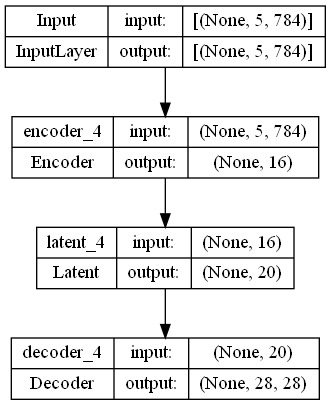

In [21]:
inputs =  Input(shape = (5, 784), name = 'Input' ) 
encoder =  Encoder(layer_sizes = [64, 32, 16])
latent = Latent(encoder)
decoder = Decoder(latent)

autoencoder = Sequential([inputs, encoder, latent, decoder ])
plot_model(autoencoder, show_shapes=True, show_layer_names=True)

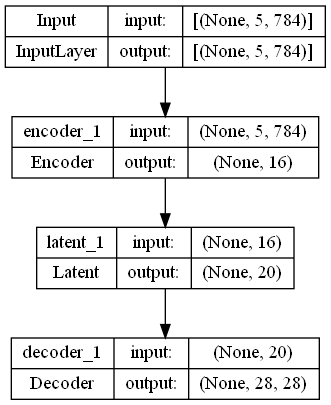

In [10]:
inputs =  Input(shape = (5, 784), name = 'Input' ) 
encoder =  Encoder(layer_sizes = [64, 32, 16])
latent = Latent(encoder)
decoder = Decoder(latent)

x = encoder(inputs)
x = latent(x)
outputs = decoder(x)

autoencoder = Model(inputs=inputs, outputs=outputs)
plot_model(autoencoder, show_shapes=True, show_layer_names=True)

# Main

In [13]:
data = pd.read_csv('Data/mnist_train_small.csv')
data = data.drop('label', axis = 1).to_numpy()

# Normalize the data to a range of [0 1] and convert to float
data = data.astype('float32') / 255.0

x_train = data.reshape(data.shape[0],28,28)

# Model
inputs =  Input(shape = x_train.shape[1:], name = 'Input' ) 
encoder =  Encoder(layer_sizes = [200])
latent = Latent(encoder)
decoder = Decoder(latent)

autoencoder = Sequential([inputs, encoder, latent, decoder ])

In [14]:
# Compile the autoencoder model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder model
history = autoencoder.fit(x_train, x_train, epochs=100, batch_size=32)


Epoch 1/100
625/625 [==============================] - 2s 3ms/step - loss: 0.0428
Epoch 2/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0250
Epoch 3/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0223
Epoch 4/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0208
Epoch 5/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0198
Epoch 6/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0190
Epoch 7/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0184
Epoch 8/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0179
Epoch 9/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0174
Epoch 10/100
625/625 [==============================] - 2s 3ms/step - loss: 0.0171
Epoch 11/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0166
Epoch 12/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0159
Epoch 13/100


# Show results

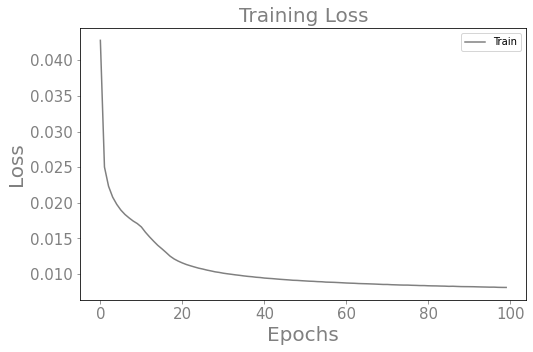

In [15]:
fig, axs = plt.subplots(figsize=(8,5))

axs.plot(history.history['loss'], color = 'gray')
axs.set_title('Training Loss', color = 'gray',fontsize =20)
axs.set_xlabel('Epochs', color = "gray", fontsize =20)
axs.set_ylabel('Loss', color = "gray", fontsize =20)
axs.tick_params(axis ='both', colors = 'gray', labelsize = 15)
axs.legend(['Train'])

plt.show()

625/625 [==============================] - 1s 795us/step


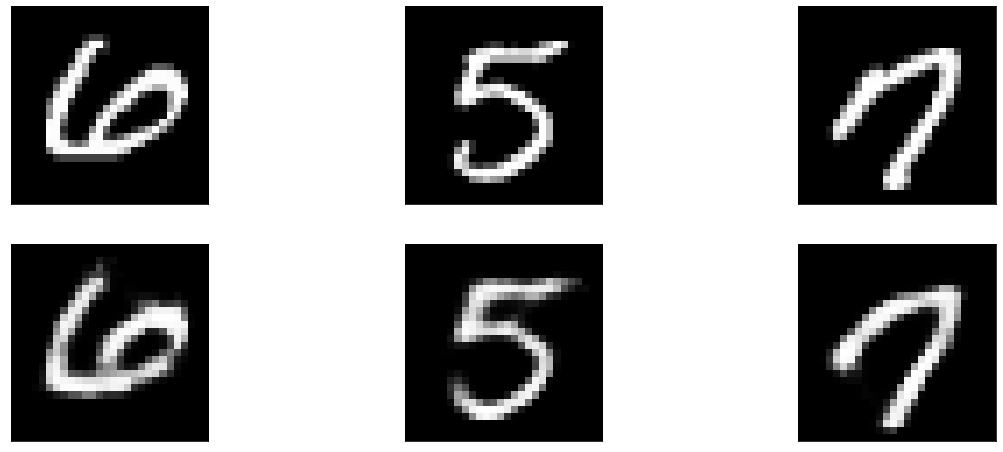

In [16]:

n = 3
plt.figure(figsize=(20, 8))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Reconstructed images
    autoencoder.predict(x_train)
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(autoencoder.predict(x_train)[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()